# Neurodynamics Analysis

**Contents**:

- [Phase Plane Analysis](#Phase-Plane-Analysis)
- [Bifurcation Analysis](#Bifurcation-Analysis)
- [Fast-Slow System Bifurcation](#Fast-Slow-System-Bifurcation)

In addition to the flexible and effecient *neurodynamics simulation*, another ambition of BrainPy is to provide an integrative platform for **neurodynamics analysis**.

As is known to us all, dynamics analysis is necessary in neurodynamics. This is because blind simulation of nonlinear systems is likely to produce few results or misleading results. For example, attractors and repellors can be easily obtained through simulation by time forward and backward, while saddles can be hard to find. 

Currently, BrainPy supports neurodynamics analysis for low-dimensional dynamical systems. Specifically, BrainPy provides the following methods for dynamics analysis:

1. phase plane analysis for one-dimensional and two-dimensional systems;
2. codimension one and codimension two bifurcation analysis;
3. bifurcation analysis of the fast-slow system. 


In this section, I will illustrate how to do neuron dynamics analysis in BrainPy and how BrainPy implements it.

In [2]:
import brainpy as bp
import numpy as np

## Phase Plane Analysis

Here, I will illustrate how to do phase plane analysis by using a well-known neuron model FitzHugh-Nagumo model.

**FitzHugh-Nagumo model**

The FitzHugh-Nagumo model is given by:

$$ 
\frac {dV} {dt} = V(1 - \frac {V^2} 3) - w + I_{ext} \\
\tau \frac {dw} {dt} = V + a - b w 
$$

There are two variables $V$ and $w$, so this is a two-dimensional system with three parameters $a, b$ and $\tau$.

In [2]:
a=0.7;  b=0.8;  tau=12.5;  Vth=1.9

@bp.odeint
def int_fhn(V, w, t, Iext):
    dw = (V + a - b * w) / tau
    dV = V - V * V * V / 3 - w + Iext
    return dV, dw

Phase Plane Analysis is implemented in `brainpy.analysis.PhasePlane`. It receives the following parameters: 

- ``integrals``: The integral functions to be analysis. 
- ``target_vars``: The variables to be analuzed. It must a dictionary with the format of `{var: variable range}`.
- ``fixed_vars``: The variables to be fixed (optional).
- ``pars_update``: Parameters to update (optional).

`brainpy.analysis.PhasePlane` provides interface to analyze the system's 

- **nullcline**: The zero-growth isoclines, such as $g(x, y)=0$ and $g(x, y)=0$.
- **fixed points**: The equilibrium points of the system, which are located at all of the nullclines intersect.
- **vector filed**: The vector field of the system.
- **Trajectory**: A given simulation trajectory with the fixed variables.

Here we perform a phase plane analysis with parameters $a=0.7, b=0.8, \tau=12.5$, and input $I_{ext} = 0.8$.

plot nullcline ...
SymPy solve "int_fhn(V, w) = 0" to "w = f(V, )", success.
SymPy solve "int_fhn(V, w) = 0" to "w = f(V, )", success.
plot vector field ...
plot fixed point ...
SymPy solve derivative of "int_fhn(V, w)" by "V", success.
SymPy solve derivative of "int_fhn(V, w)" by "w", success.
SymPy solve derivative of "int_fhn(V, w)" by "V", success.
SymPy solve derivative of "int_fhn(V, w)" by "w", success.
Fixed point #1 at V=-0.27290095899729705, w=0.5338738012533786 is a unstable node.
plot trajectory ...


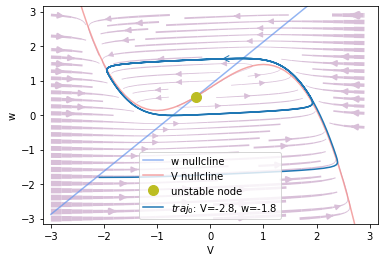

In [3]:
analyzer = bp.analysis.PhasePlane(
    integrals=int_fhn,
    target_vars={'V': [-3, 3], 'w': [-3., 3.]},
    pars_update={'Iext': 0.8})
analyzer.plot_nullcline()
analyzer.plot_vector_field()
analyzer.plot_fixed_point()
analyzer.plot_trajectory([{'V': -2.8, 'w': -1.8}],
                         duration=100.,
                         show=True)

We can see an unstable-node at the point (v=-0.27, w=0.53) inside a limit cycle. Then we can run a simulation with the same parameters and initial values to see the periodic activity that correspond to the limit cycle.

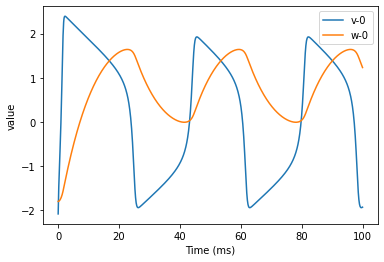

In [4]:
class FHN(bp.NeuGroup):
    target_backend = 'numpy'
    
    def __init__(self, num, **kwargs):
        self.V = np.ones(num) * -2.8
        self.w = np.ones(num) * -1.8
        self.Iext = np.zeros(num) 
        super(FHN, self).__init__(size=num, **kwargs)
    
    def update(self, _t):
        self.V, self.w = int_fhn(self.V, self.w, _t, self.Iext)

        
group = FHN(1, monitors=['V', 'w'])
group.run(100., inputs=('Iext', 0.8, '=')) 
bp.visualize.line_plot(group.mon.ts, group.mon.V, legend='v', ) 
bp.visualize.line_plot(group.mon.ts, group.mon.w, legend='w', show=True)

Note that the `fixed_vars` can be used to specify the neuron model's state `ST`, it can also be used to specify the functional arguments in integrators (like the `Iext` in `int_v()`). 

## Bifurcation Analysis

Bifurcation analysis is implemented within `brainpy.analysis.Bifurcation`. Which support codimension-1 and codimension-2 bifurcation analysis. Specifically, it receives the following parameter settings: 

- ``integrals``: The integral functions to be analysis.
- ``target_pars``: The target parameters. Must be a dictionary with the format of `{par: parameter range}`. 
- ``target_vars``: The target variables. Must be a dictionary with the format of `{var: variable range}`. 
- ``fixed_vars``: The fixed variables.
- ``pars_update``: The parameters to update.

**Codimension 1 bifurcation analysis**

We will first see the codimension 1 bifurcation anlysis of the model. For example, we vary the input $I_{ext}$ between 0 to 1 and see how the system change it's stability.

plot bifurcation ...
SymPy solve "int_fhn(V, w, Iext) = 0" to "w = f(V, Iext)", success.
SymPy solve derivative of "int_fhn(V, w, Iext)" by "V", success.
SymPy solve derivative of "int_fhn(V, w, Iext)" by "w", success.
SymPy solve derivative of "int_fhn(V, w, Iext)" by "V", success.
SymPy solve derivative of "int_fhn(V, w, Iext)" by "w", success.


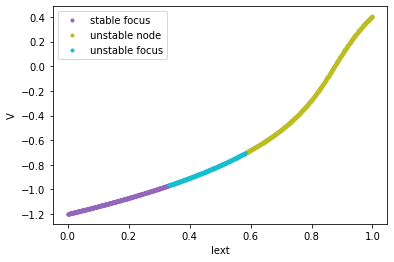

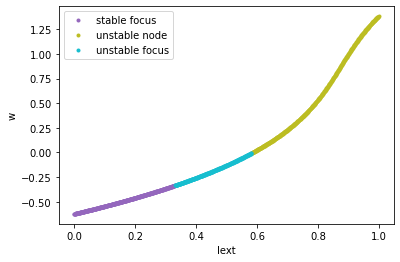

In [5]:
analyzer = bp.analysis.Bifurcation(
    integrals=int_fhn,
    target_pars={'Iext': [0., 1.]},
    target_vars={'V': [-3, 3], 'w': [-3., 3.]},
    numerical_resolution=0.001,
)
analyzer.plot_bifurcation(show=True)

**Codimension 2 bifurcation analysis**

We simulaneously change $I_{ext}$ and parameter $a$.

plot bifurcation ...
SymPy solve "int_fhn(V, w, a, Iext) = 0" to "w = f(V, a,Iext)", success.
SymPy solve derivative of "int_fhn(V, w, a, Iext)" by "V", success.
SymPy solve derivative of "int_fhn(V, w, a, Iext)" by "w", success.
SymPy solve derivative of "int_fhn(V, w, a, Iext)" by "V", success.
SymPy solve derivative of "int_fhn(V, w, a, Iext)" by "w", success.


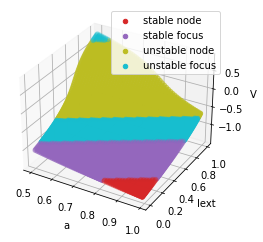

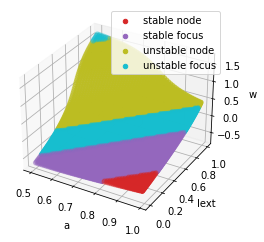

In [6]:
from collections import OrderedDict

analyzer = bp.analysis.Bifurcation(
    integrals=int_fhn,
    target_pars=OrderedDict(a=[0.5, 1.], Iext=[0., 1.]),
    target_vars=OrderedDict(V=[-3, 3], w=[-3., 3.]),
    numerical_resolution=0.01,
)
analyzer.plot_bifurcation(show=True)

## Fast-Slow System Bifurcation

BrainPy also provides a tool for fast-slow system bifurcation analysis by using `brainpy.analysis.FastSlowBifurcation`. This method is proposed by John Rinzel [1, 2, 3]. (J Rinzel, 1985, 1986, 1987) proposed that in a fast-slow dynamical system, we can treat the slow variables as the bifurcation parameters, and then study how the different value of slow variables affect the bifurcation of the fast sub-system.


`brainpy.analysis.FastSlowBifurcation` is very usefull in the bursting neuron analysis. I will illustrate this by using the Hindmarsh-Rose model. The Hindmarsh–Rose model of neuronal activity is aimed to study the spiking-bursting behavior of the membrane potential observed in experiments made with a single neuron. Its dynamics are governed by:

$$
\begin{align}
\frac{d V}{d t} &= y - a V^3 + b V^2 - z + I\\
\frac{d y}{d t} &= c - d V^2 - y\\
\frac{d z}{d t} &= r (s (V - V_{rest}) - z)
\end{align}
$$






First of all, let's define the Hindmarsh–Rose model with BrainPy. 

In [7]:
a = 1.; b = 3.; c = 1.; d = 5.; s = 4. 
x_r = -1.6; r = 0.001; Vth = 1.9

@bp.odeint(method='rk4', dt=0.02)
def int_hr(x, y, z, t, Isyn):
    dx = y - a * x ** 3 + b * x * x - z + Isyn
    dy = c - d * x * x - y
    dz = r * (s * (x - x_r) - z)
    return dx, dy, dz

We now can start to analysis the underlying bifurcation mechanism.

plot bifurcation ...
SymPy solve "int_hr(x, y, z) = 0" to "y = f(x, z)", success.
SymPy solve derivative of "int_hr(x, y, z)" by "x", success.
SymPy solve derivative of "int_hr(x, y, z)" by "y", success.
SymPy solve derivative of "int_hr(x, y, z)" by "x", success.
SymPy solve derivative of "int_hr(x, y, z)" by "y", success.
plot trajectory ...


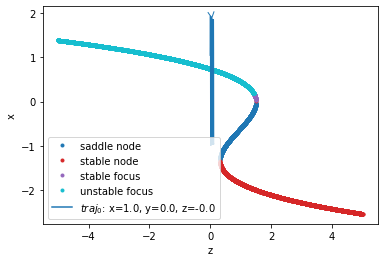

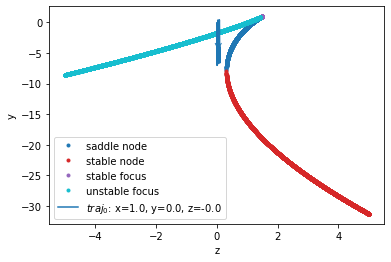

In [8]:
analyzer = bp.analysis.FastSlowBifurcation(
    integrals=int_hr,
    fast_vars={'x': [-3, 3], 'y': [-10., 5.]},
    slow_vars={'z': [-5., 5.]},
    pars_update={'Isyn': 0.5},
    numerical_resolution=0.001
)
analyzer.plot_bifurcation()
analyzer.plot_trajectory([{'x': 1., 'y': 0., 'z': -0.0}],
                         duration=100.,
                         show=True)

**References**:

[1] Rinzel, John. "Bursting oscillations in an excitable membrane model." In Ordinary and partial differential  equations, pp. 304-316. Springer, Berlin, Heidelberg, 1985.
           
[2] Rinzel, John , and Y. S. Lee . On Different Mechanisms for Membrane Potential Bursting. Nonlinear Oscillations in Biology and Chemistry. Springer Berlin Heidelberg, 1986.

[3] Rinzel, John. "A formal classification of bursting mechanisms in excitable systems." In Mathematical topics in population biology, morphogenesis and neurosciences, pp. 267-281. Springer, Berlin, Heidelberg, 1987.


**Outlook**

In future, we will provide more analysis methods for various dynamical systems. We now also start to consider how to analyze the network model. Of course, we welcome your contributions on neurodynamics analysis. 